In [1]:
import numpy as np
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
import cv2
from rasterio.mask import mask
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union, unary_union
from rasterio.features import rasterize
import os
from patchify import patchify

In [2]:
path = "T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [3]:
os.makedirs(r"train_img_1", exist_ok=True)
os.makedirs(r"train_mask_1", exist_ok=True)
os.makedirs(r"Data", exist_ok=True)
os.makedirs(r"Data\train_images", exist_ok=True)
os.makedirs(r"Data\train_mask", exist_ok=True)
os.makedirs(r"Data\train_images\train", exist_ok=True)
os.makedirs(r"Data\train_mask\train", exist_ok=True)

In [5]:
train_df = gpd.read_file(r"C:\Users\Eyggen\Desktop\jupyter\inteship\four_q\masks\Masks_T36UXV_20190427.shp")
train_df = train_df[train_df["geometry"].notna()]
train_df.crs = {"init" : "epsg:4200"}
train_df = train_df.to_crs({"init" : raster_meta["crs"]["init"]})

C:\Users\Eyggen\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


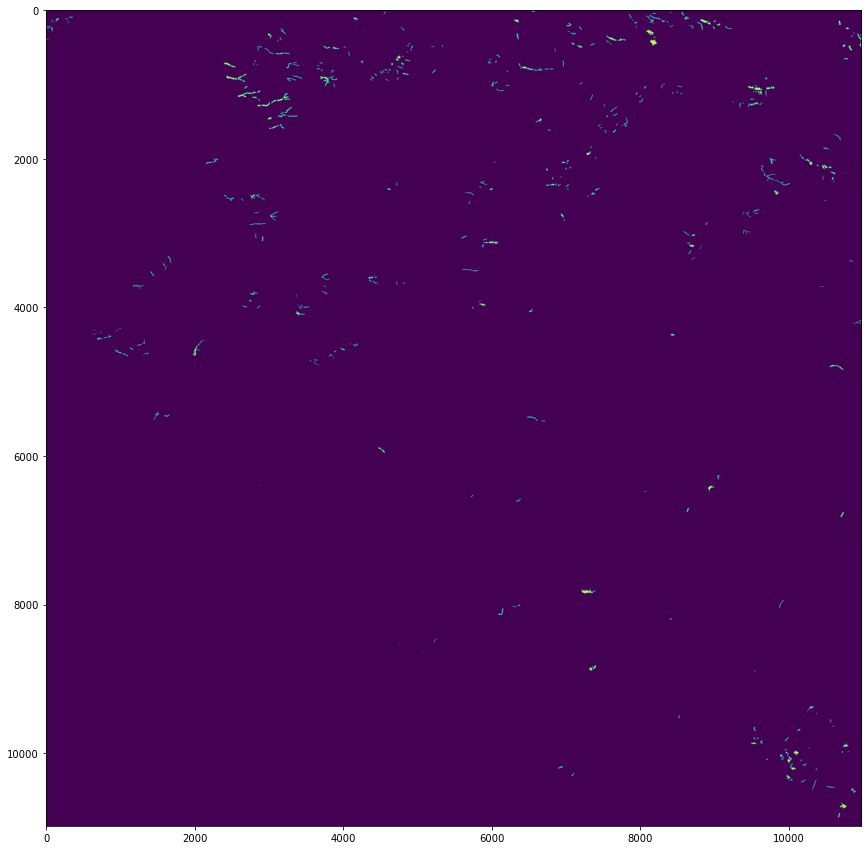

In [6]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask
plt.figure(figsize=(15,15))
plt.imshow(mask)

In [7]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

In [8]:
with rasterio.open("mask.jp2", "r", driver="JP2OpenJPEG") as mask:
    mask_img = mask.read()
    mask_meta = mask.meta

In [9]:
cv2.imwrite("savedImage.png", reshape_as_image(mask_img))

True

In [10]:
mask_img = cv2.imread('savedImage.png', cv2.IMREAD_GRAYSCALE)
#mask_img = np.array(img, dtype=bool)
#np.unique(mask_img,  return_counts=True)

In [11]:
satellite_img = reshape_as_image(raster_img)
mask_img = mask_img

In [12]:
type(mask_img)

numpy.ndarray

In [13]:
def patch_img(img, root_dir, shape):
    size_x = (img.shape[1]//128)*128
    size_y = (img.shape[1]//128)*128
    img = img[0:size_x, 0:size_y]
    print(img.shape)
    patches_img = patchify(img, shape, step=128)
    patches_img = np.squeeze(patches_img)
    print(patches_img.shape)
    for i in range(patches_img.shape[0]):
        print(i)
        for j in range(patches_img.shape[1]):
            #print(j)
            single_patch = patches_img[i,j,:,:]
            try:
                img_image = cv2.cvtColor(single_patch, cv2.COLOR_RGB2BGR)
            except:
                img_image = single_patch
            cv2.imwrite(root_dir+str(i)+str(j)+".tif", img_image)

In [14]:
img_dir = r"\train_img_1\train_img"
mask_dir = r"\train_mask_1\train_mask"
patch_img(satellite_img, img_dir, (128,128,3))
patch_img(mask_img, mask_dir, (128,128))

(10880, 10880, 3)
(85, 85, 128, 128, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
(10880, 10880)
(85, 85, 128, 128)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [15]:
img_list = os.listdir(r"train_img_1")
mask_list = os.listdir(r"train_mask_1")

In [16]:
img_dir = r"train_img_1"
mask_dir = r"train_mask_1"
for img in range(len(img_list)):
    img_name=img_list[img]
    mask_name=mask_list[img]
    
    temp_img = cv2.imread(img_dir+f"\{img_name}")
    temp_mask = cv2.imread(mask_dir+f"\{mask_name}", 0)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.008:
        cv2.imwrite(r"Data\train_images\train"+f"\{img_name}", temp_img)
        cv2.imwrite(r"Data\train_mask\train"+f"\{img_name}", temp_mask)